In [1]:
import json

def write_dict_into_json(dictionary, filename):
    with open(filename, "w") as write_file:
        json.dump(dictionary, write_file, indent=4)

In [2]:
import pandas as pd
from loguru import logger
import torch
import torch.nn.functional as F
from datetime import datetime as dt
import os
from dateutil.relativedelta import relativedelta  # type: ignore
import functools

from process_data import *
from constants import *
from unsup_model import *
from model import *
from evaluate import *

start_date = dt.strptime("2021-10-24", "%Y-%m-%d").date()
if start_date == dt.strptime(MAX_START_DATE, "%Y-%m-%d").date():
    raise Exception("Stop Simulation")
end_date, nxt_start_date = split_date_by_period_months(start_date, TOTAL_MONTHS_PER_ITERATION)
print(start_date, end_date)
directory = "/Users/yhchan/Downloads/FYP/data/processed"
reviews = pd.read_parquet(f"{directory}/reviews_with_interactions.parquet")
listings = pd.read_parquet(f"{directory}/listings_with_interactions.parquet")

config = {
        "start_date": start_date,
        "end_date": end_date,
        "learning_rate": 0.01,
        "hidden_channels": 64,
        "train_batch_size": 128,
        "test_batch_size": 128,
        "train_num_neighbours": [10, 10],
        "test_num_neighbours": [-1],
        "train_split_period_months": 10,
        "total_months_of_data": TOTAL_MONTHS_PER_ITERATION,
        "rec_K":5

    }

# Split into train, test and test for cold start scenario
(
    train_reviews,
    train_listings,
    train_reviewers,
    test_reviews,
    test_listings,
    test_reviewers,
) = main_train_test(
    reviews,
    listings,
    start_date,
    end_date,
    config["train_split_period_months"],
)

cold_start_test_reviews = filter_test_data_by_scenario(
    train_reviews, test_reviews, "reviewer_id", "cold_start_new_user"
)
cold_start_test_listings, cold_start_test_reviewers = build_partitioned_data(
    cold_start_test_reviews, listings
)
# Build Graph
involved_reviews = pd.concat([train_reviews, test_reviews])
involved_listings, involved_reviewers = build_partitioned_data(involved_reviews, listings)
involved_data = build_heterograph(involved_reviews, involved_listings, involved_reviewers, True)
train_data = build_heterograph(train_reviews, train_listings, train_reviewers, True)
test_data = build_heterograph(test_reviews, test_listings, test_reviewers, True)
cold_start_test_data = build_heterograph(cold_start_test_reviews, cold_start_test_listings, cold_start_test_reviewers, True)
print("Whole Graph", involved_data)
print("Training Heterogenous Graph", train_data)
print("Test Heterogenous Graph", test_data)
print("Test Heterogenous Graph (Cold Start Scenerio)", cold_start_test_data)

involved_listings2dict = get_entity2dict(involved_listings, "listing_id")
reverse_involved_listings2dict = {k: v for v, k in involved_listings2dict.items()}

2021-10-24 2022-10-23


2023-04-26 23:30:51.398 | INFO     | process_data:main_train_test:140 - Split df into train and test portion
/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/process_data.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525682339/work/torch/csrc/utils/tensor_numpy.cpp:205.)
  temp = torch.from_numpy(val).view(-1, 1).to(torch.float32)


Whole Graph HeteroData(
  listing={ x=[18523, 158] },
  user={ x=[394551, 384] },
  (user, rates, listing)={
    edge_index=[2, 408596],
    edge_label=[408596],
    edge_label_index=[2, 408596]
  },
  (listing, rev_rates, user)={ edge_index=[2, 408596] }
)
Training Heterogenous Graph HeteroData(
  listing={ x=[17229, 158] },
  user={ x=[324135, 384] },
  (user, rates, listing)={
    edge_index=[2, 334678],
    edge_label=[334678],
    edge_label_index=[2, 334678]
  },
  (listing, rev_rates, user)={ edge_index=[2, 334678] }
)
Test Heterogenous Graph HeteroData(
  listing={ x=[14380, 158] },
  user={ x=[72447, 384] },
  (user, rates, listing)={
    edge_index=[2, 73918],
    edge_label=[73918],
    edge_label_index=[2, 73918]
  },
  (listing, rev_rates, user)={ edge_index=[2, 73918] }
)
Test Heterogenous Graph (Cold Start Scenerio) HeteroData(
  listing={ x=[14254, 158] },
  user={ x=[70416, 384] },
  (user, rates, listing)={
    edge_index=[2, 71775],
    edge_label=[71775],
    edge_l

# Evaluation of RecSys Metrics


In [3]:
path_prefix = './best_models'
# Epoch 2
best_unsupervised_model_path = f"{path_prefix}/unsupervised_graphsage_state_dict.pt"
best_unsupervised_model = load_model(best_unsupervised_model_path, config["hidden_channels"], involved_data)
# Epoch 164
best_rating_weighted_model_path = f"{path_prefix}/rating_weighted_graphsage_state_dict.pt"
best_rating_weighted_model = load_model(best_rating_weighted_model_path, config["hidden_channels"], involved_data)
K_list = [1,3,5,10]
u2i_unsupervised_hr = []
u2i_unsupervised_cov = []
i2i_unsupervised_hr = []
i2i_unsupervised_cov = []

u2i_rating_hr = []
u2i_rating_cov = []
i2i_rating_hr = []
i2i_rating_cov = []

for K in K_list:
    run_eval_wrapper = functools.partial(
        run_eval,
        involved_data,
        involved_reviewers,
        involved_listings2dict,
        reverse_involved_listings2dict,
        test_reviews,
        test_reviewers,
        K,
    )
    u2i_hit_rate_u, u2i_coverage_u, i2i_hit_rate_u, i2i_coverage_u = run_eval_wrapper(best_unsupervised_model)
    
    u2i_unsupervised_hr.append(u2i_hit_rate_u)
    u2i_unsupervised_cov.append(u2i_coverage_u)
    i2i_unsupervised_hr.append(i2i_hit_rate_u)
    i2i_unsupervised_cov.append(i2i_coverage_u)
    
    u2i_hit_rate_r, u2i_coverage_r, i2i_hit_rate_r, i2i_coverage_r = run_eval_wrapper(best_rating_weighted_model)

    u2i_rating_hr.append(u2i_hit_rate_r)
    u2i_rating_cov.append(u2i_coverage_r)
    i2i_rating_hr.append(i2i_hit_rate_r)
    i2i_rating_cov.append(i2i_coverage_r)
    
u2i_model_metrics = {
    'Unsupervised GraphSAGE': {'Hit Rate': u2i_unsupervised_hr,
                               'Coverage': u2i_unsupervised_cov
                              },
    'Rating Weighted GraphSAGE': {'Hit Rate': u2i_rating_hr,
                                  'Coverage': u2i_rating_cov
                                 },
}

i2i_model_metrics = {
    'Unsupervised GraphSAGE': {'Hit Rate': i2i_unsupervised_hr,
                               'Coverage': i2i_unsupervised_cov
                              },
    'Rating Weighted GraphSAGE': {'Hit Rate': i2i_rating_hr,
                                  'Coverage': i2i_rating_cov
                                 },
}

K = 1
Start generating embeddings
Finish generating embeddings
Start u2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 72447, Length of ground truth: 72447
Count of hit & non-hit:  Counter({0: 72356, 1: 91})
n_unique_recommendations:  1156
n_available_listings:  18523
u2i hit rate:  0.0012560906593785802
u2i coverage:  0.062408897046914644
Start i2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 1349, Length of ground truth: 1349
Count of hit & non-hit:  Counter({0: 1346, 1: 3})
n_unique_recommendations:  1019
n_available_listings:  18523
i2i hit rate:  0.002223869532987398
i2i coverage:  0.055012686929762994
K = 1
Start generating embeddings
Finish generating embeddings
Start u2i recommendation
Length of recommendations: 72447, Length of ground truth: 72447
Count of hit & non-hit:  Counter({1: 71611, 0: 836})
n_unique_recommendations:  14342
n_available_listings:  18523
u2i hit rate:  0.9884605297665879
u2i coverage:  0.7742806240889705
Start i2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 1349, Length of ground truth: 1349
Count of hit & non-hit:  Counter({0: 1300, 1: 49})
n_unique_recommendations:  1139
n_available_listings:  18523
i2i hit rate:  0.0363232023721275
i2i coverage:  0.0614911191491659
K = 3
Start generating embeddings
Finish generating embeddings
Start u2i recommendation
Length of recommendations: 72447, Length of ground truth: 72447
Count of hit & non-hit:  Counter({0: 72136, 1: 311})
n_unique_recommendations:  2587
n_available_listings:  18523
u2i hit rate:  0.0042927933523817415
u2i coverage:  0.1396642012632943
Start i2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 1349, Length of ground truth: 1349
Count of hit & non-hit:  Counter({0: 1341, 1: 8})
n_unique_recommendations:  2860
n_available_listings:  18523
i2i hit rate:  0.005930318754633061
i2i coverage:  0.1544026345624359
K = 3
Start generating embeddings
Finish generating embeddings
Start u2i recommendation
Length of recommendations: 72447, Length of ground truth: 72447
Count of hit & non-hit:  Counter({1: 72327, 0: 120})
n_unique_recommendations:  17422
n_available_listings:  18523
u2i hit rate:  0.9983436167129074
u2i coverage:  0.9405603843869783
Start i2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 1349, Length of ground truth: 1349
Count of hit & non-hit:  Counter({0: 1276, 1: 73})
n_unique_recommendations:  3068
n_available_listings:  18523
i2i hit rate:  0.054114158636026685
i2i coverage:  0.1656319170760676
K = 5
Start generating embeddings
Finish generating embeddings
Start u2i recommendation
Length of recommendations: 72447, Length of ground truth: 72447
Count of hit & non-hit:  Counter({0: 71926, 1: 521})
n_unique_recommendations:  3327
n_available_listings:  18523
u2i hit rate:  0.00719146410479385
u2i coverage:  0.17961453328294552
Start i2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 1349, Length of ground truth: 1349
Count of hit & non-hit:  Counter({0: 1339, 1: 10})
n_unique_recommendations:  4416
n_available_listings:  18523
i2i hit rate:  0.007412898443291327
i2i coverage:  0.23840630567402687
K = 5
Start generating embeddings
Finish generating embeddings
Start u2i recommendation
Length of recommendations: 72447, Length of ground truth: 72447
Count of hit & non-hit:  Counter({1: 72362, 0: 85})
n_unique_recommendations:  18181
n_available_listings:  18523
u2i hit rate:  0.998826728504976
u2i coverage:  0.9815364681747017
Start i2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 1349, Length of ground truth: 1349
Count of hit & non-hit:  Counter({0: 1270, 1: 79})
n_unique_recommendations:  4753
n_available_listings:  18523
i2i hit rate:  0.05856189770200148
i2i coverage:  0.2565999028235167
K = 10
Start generating embeddings
Finish generating embeddings
Start u2i recommendation
Length of recommendations: 72447, Length of ground truth: 72447
Count of hit & non-hit:  Counter({0: 71517, 1: 930})
n_unique_recommendations:  4819
n_available_listings:  18523
u2i hit rate:  0.012836970474967908
u2i coverage:  0.2601630405441883
Start i2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 1349, Length of ground truth: 1349
Count of hit & non-hit:  Counter({0: 1329, 1: 20})
n_unique_recommendations:  7333
n_available_listings:  18523
i2i hit rate:  0.014825796886582653
i2i coverage:  0.39588619554067916
K = 10
Start generating embeddings
Finish generating embeddings
Start u2i recommendation
Length of recommendations: 72447, Length of ground truth: 72447
Count of hit & non-hit:  Counter({1: 72394, 0: 53})
n_unique_recommendations:  18503
n_available_listings:  18523
u2i hit rate:  0.9992684307148674
u2i coverage:  0.9989202612967661
Start i2i recommendation
Length of recommendations: 1349, Length of ground truth: 1349
Count of hit & non-hit:  Counter({0: 1243, 1: 106})
n_unique_recommendations:  8019
n_available_listings:  18523
i2i hit rate:  0.07857672349888807
i2i coverage:  0.4329212330615991


/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


In [4]:
write_dict_into_json(u2i_model_metrics, "u2i_model_metrics.json")
write_dict_into_json(i2i_model_metrics, "i2i_model_metrics.json")


### Model Comparison

## Evaluation

In [5]:
import matplotlib.pyplot as plt
import numpy as np
def plot_metrics_over_k(model_metrics, title_suffix):
    # Set up the line chart
    fig, ax = plt.subplots()

    # Plot the performance metrics for each model
    xticks = [1,3,5,10]
    for label, metrics in model_metrics.items():
        for metric_label, metric_values in metrics.items():
            ax.plot(xticks, metric_values, label=label + ' ' + metric_label)

    # Set the x-axis label and tick values
    ax.set_xlabel('K')
    
#     ax.set_xticks(xticks)
    
    # Set the y-axis label and limits
    ax.set_ylabel('Performance Metrics')

    # Set the chart title
    plt.title(f'Model Performance Over K {title_suffix}')

    # Add a legend to the chart
    ax.legend()

    # Display the chart
    plt.show()

def plot_bar_chart(model_metrics, title_suffix):

    # Define the metric names
    metric_names = list(model_metrics.keys())

    # Define the model names
    model_names = list(model_metrics[metric_names[0]].keys())
    width = 0.2

    # Set up the bar chart
    fig, ax = plt.subplots()

    # Set the width of the bars

    # Loop through each model and plot the bar for each metric
    for i, model_name in enumerate(model_names):
        # Get the values for the current model across all metrics
        model_values = [model_metrics[metric_name][model_name] for metric_name in metric_names]

        # Set the x-axis values for the current model
        x_values = np.arange(len(model_values)) + (i * width)

        # Plot the bar for the current model for each metric
        ax.bar(x_values, model_values, width, label=model_name)

    # Set the x-axis label and tick values
    ax.set_xlabel('Metrics')
    ax.set_xticks(np.arange(len(metric_names)) + (len(model_names) / 2 - 0.5) * width)
    ax.set_xticklabels(metric_names)

    # Set the y-axis label and limits
    ax.set_ylabel('Performance Metrics')

    # Set the chart title
    plt.title(f'Model Performance Comparison {title_suffix}')

    # Add a legend to the chart
    plt.legend(loc='upper right', bbox_to_anchor=(1.55, 1))

    # Display the chart
    plt.show()





# u2i_model_metrics = {
#     'Unsupervised GraphSAGE': {'Hit Rate': [0.003188537827653319, 0.009165320855245905, 0.01522492304719312, 0.029649260838958136],
#                                'Coverage': [0.0644604005830589, 0.1301625006748367, 0.16590185175187605, 0.21778329644226097]
#                               },
#     'Rating Weighted GraphSAGE': {'Hit Rate': [0.9891368862754841, 0.9986472869822077, 0.9991856115505128, 0.9994340690435767],
#                                   'Coverage': [0.7746045456999406, 0.9402364627760083, 0.9807266641472764, 0.999136209037413]
#                                  },
# }

# i2i_model_metrics = {
#     'Unsupervised GraphSAGE': {'Hit Rate': [0.005930318754633061, 0.011860637509266123, 0.01630837657524092, 0.02223869532987398],
#                                'Coverage': [0.06143713221400421, 0.16935701560222427, 0.26102683150677536, 0.4316795335528802]
#                               },
#     'Rating Weighted GraphSAGE': {'Hit Rate': [0.037064492216456635, 0.05189028910303929, 0.05559673832468495, 0.06523350630096368],
#                                   'Coverage': [0.06105922366787238, 0.16995087188900287, 0.2597311450628948, 0.44490633266749446]
#                                  },
# }


In [10]:
u2i_model_metrics

{'Unsupervised GraphSAGE': {'Hit Rate': [0.0012560906593785802,
   0.0042927933523817415,
   0.00719146410479385,
   0.012836970474967908],
  'Coverage': [0.062408897046914644,
   0.1396642012632943,
   0.17961453328294552,
   0.2601630405441883]},
 'Rating Weighted GraphSAGE': {'Hit Rate': [0.9884605297665879,
   0.9983436167129074,
   0.998826728504976,
   0.9992684307148674],
  'Coverage': [0.7742806240889705,
   0.9405603843869783,
   0.9815364681747017,
   0.9989202612967661]}}

In [11]:
i2i_model_metrics

{'Unsupervised GraphSAGE': {'Hit Rate': [0.002223869532987398,
   0.005930318754633061,
   0.007412898443291327,
   0.014825796886582653],
  'Coverage': [0.055012686929762994,
   0.1544026345624359,
   0.23840630567402687,
   0.39588619554067916]},
 'Rating Weighted GraphSAGE': {'Hit Rate': [0.0363232023721275,
   0.054114158636026685,
   0.05856189770200148,
   0.07857672349888807],
  'Coverage': [0.0614911191491659,
   0.1656319170760676,
   0.2565999028235167,
   0.4329212330615991]}}

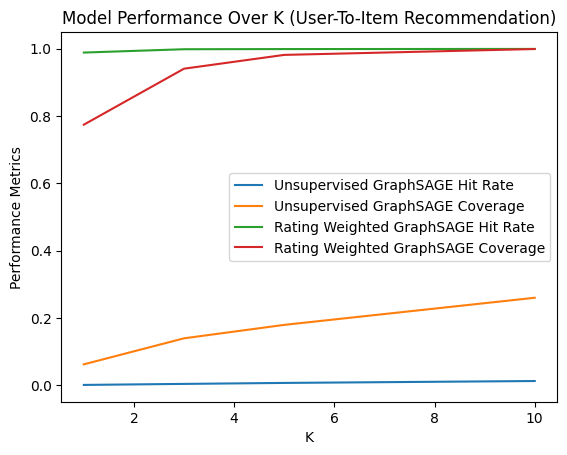

In [6]:
# u2i when K increases
plot_metrics_over_k(u2i_model_metrics, "(User-To-Item Recommendation)")

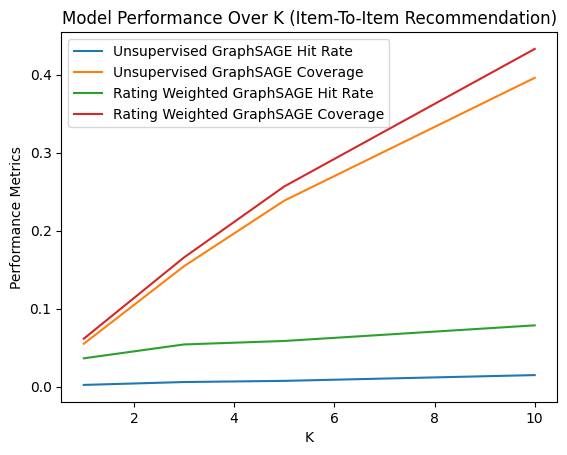

In [7]:
# i2i when K increases
plot_metrics_over_k(i2i_model_metrics, "(Item-To-Item Recommendation)")

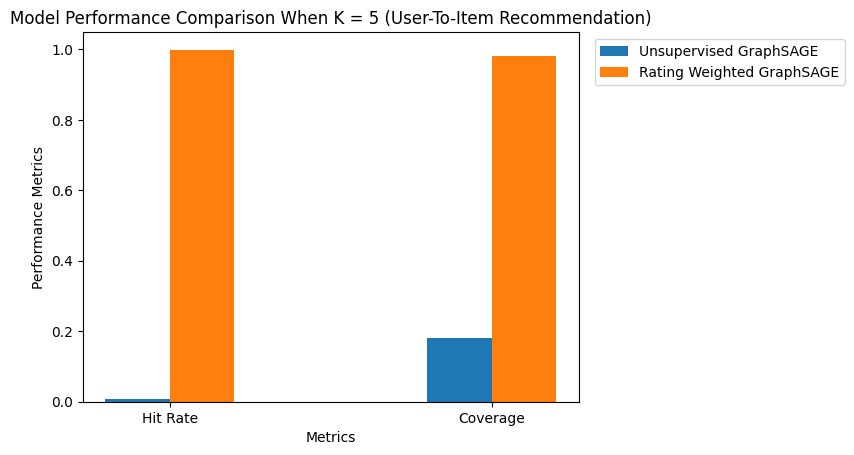

In [8]:
# u2i when K == 5

idx = 2 # K==5
u2i_model_metrics_k_eq_5 = {
    'Hit Rate':{'Unsupervised GraphSAGE':u2i_model_metrics['Unsupervised GraphSAGE']['Hit Rate'][idx],
                'Rating Weighted GraphSAGE': u2i_model_metrics['Rating Weighted GraphSAGE']['Hit Rate'][idx]
               },
    'Coverage':{'Unsupervised GraphSAGE':u2i_model_metrics['Unsupervised GraphSAGE']['Coverage'][idx],
                'Rating Weighted GraphSAGE': u2i_model_metrics['Rating Weighted GraphSAGE']['Coverage'][idx]
               },
}


plot_bar_chart(u2i_model_metrics_k_eq_5 , "When K = 5 (User-To-Item Recommendation)")


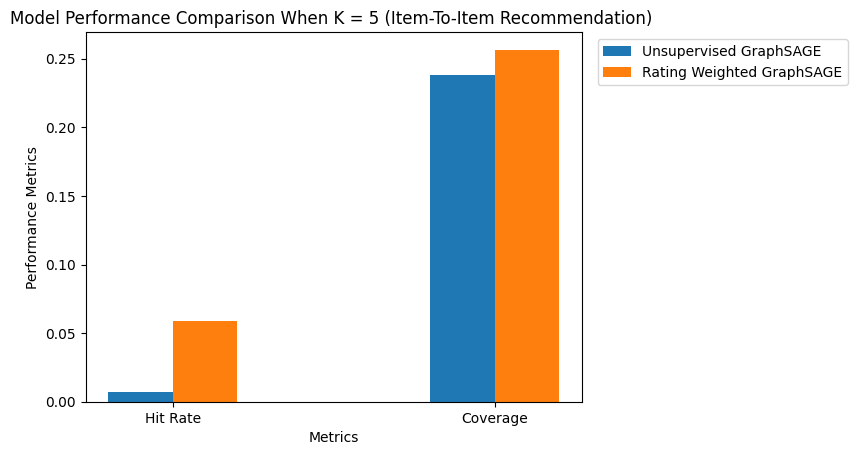

In [9]:
# i2i when K == 5
i2i_model_metrics_k_eq_5 = {
    'Hit Rate':{'Unsupervised GraphSAGE':i2i_model_metrics['Unsupervised GraphSAGE']['Hit Rate'][idx],
                'Rating Weighted GraphSAGE': i2i_model_metrics['Rating Weighted GraphSAGE']['Hit Rate'][idx]
               },
    'Coverage':{'Unsupervised GraphSAGE':i2i_model_metrics['Unsupervised GraphSAGE']['Coverage'][idx],
                'Rating Weighted GraphSAGE': i2i_model_metrics['Rating Weighted GraphSAGE']['Coverage'][idx]
               },
}

plot_bar_chart(i2i_model_metrics_k_eq_5, "When K = 5 (Item-To-Item Recommendation) ")
